Author: Nelson Liu

Email: [nliu@uncharted.software](mailto:nliu@uncharted.software)

# Typing Example

Example use case for multi-stratification with multiple node types:

1. SIRV `x` Age = SIRV_Age
2. SIRV_Age `x` Travel = SIRV_Age_Travel

SIRV: SIR compartmental model with vaccination and vaccine production
Age: Age-group contact model
Travel: Travel model

In [1]:
# Libraries
using AlgebraicPetri, AlgebraicPetri.TypedPetri
using Catlab.Programs, Catlab.Graphics
using Catlab.CategoricalAlgebra
using GraphViz

## Define Ontology

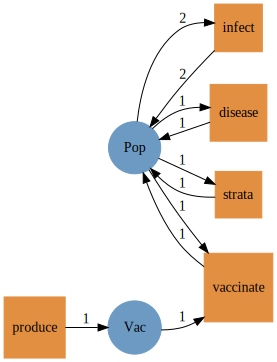

In [31]:
const ontology = LabelledPetriNet(
    [:Pop, :Vac],
    :infect => ((:Pop, :Pop) => (:Pop, :Pop)),
    :disease => (:Pop => :Pop),
    :strata => (:Pop => :Pop),
    :vaccinate => ((:Pop, :Vac) => :Pop),
    :produce => (() => :Vac),
)

Graph(ontology)

## Define Base Models

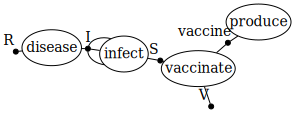

In [32]:
# Lotka-Volterra model of humans predating on multiplying dodos
# sirv_uwd = @relation () where (vaccine::Vaccine, S::Pop, V::Pop, I::Pop, R::Pop) begin
sirv_uwd = @relation () where (S::Pop, I::Pop, R::Pop, vaccine::Vac, V::Pop) begin
    infect(S, I, I, I)
    disease(I, R)
    vaccinate(S, vaccine, V)
    produce(vaccine)
end

to_graphviz(sirv_uwd, box_labels = :name, junction_labels = :variable)

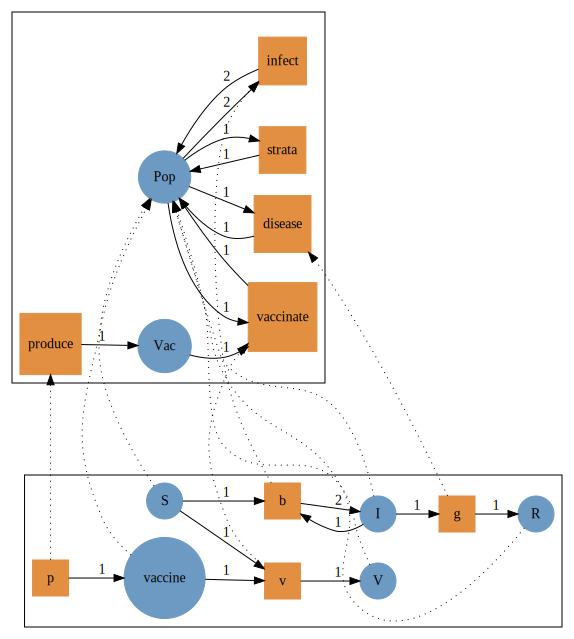

In [33]:

tnames = [:b, :g, :v, :p]
typed_sirv = oapply_typed(ontology, sirv_uwd, tnames)
Graph(typed_sirv)

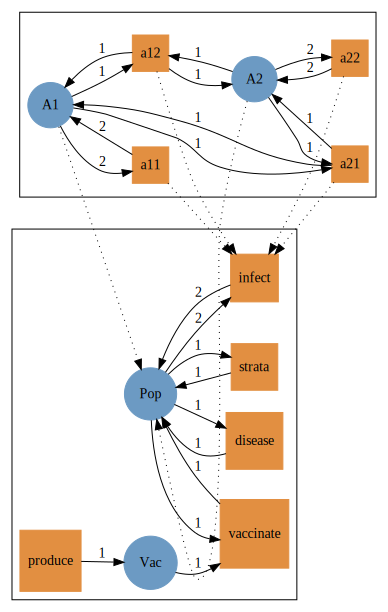

In [18]:
# Age-group infection/contact model
N = 2
# snames = [Symbol("A$i") for i in 1:N]
# typed_age = pairwise_id_typed_petri(ontology, :Pop, :infect, snames)
age_uwd = @relation () where (A1::Pop, A2::Pop) begin
    infect(A1, A1, A1, A1)
    infect(A1, A2, A1, A2)
    infect(A2, A1, A2, A1)
    infect(A2, A2, A2, A2)
end
tnames = [:a11, :a12, :a21, :a22]
typed_age = oapply_typed(ontology, age_uwd, tnames)

Graph(typed_age)


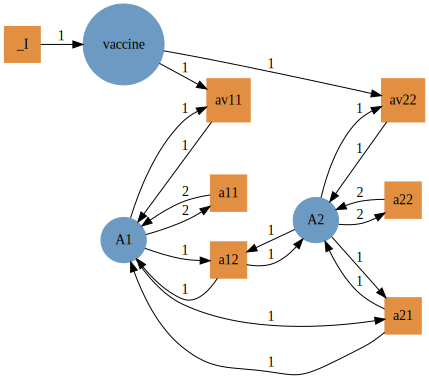

In [45]:

# ^ Not sufficient, need to include "vaccinate" and "produce" interactions to correctly stratify with SIRV
# _I = 1.0 (dummy rate)
agev_uwd = @relation () where (A1::Pop, A2::Pop, vaccine::Vac) begin
    infect(A1, A1, A1, A1)
    infect(A1, A2, A1, A2)
    infect(A2, A1, A2, A1)
    infect(A2, A2, A2, A2)
    vaccinate(A1, vaccine, A1)
    vaccinate(A2, vaccine, A2)
    produce(vaccine)
end
tnames = [:a11, :a12, :a21, :a22, :av11, :av22, :_I]
typed_agev = oapply_typed(ontology, agev_uwd, tnames)

Graph(dom(typed_agev))

## Stratification

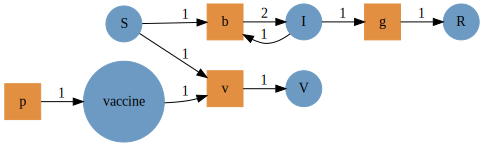

In [28]:
# Augment SIRV model
typed_sirv_aug = add_reflexives(
    typed_sirv,
    [[], [], [], [], []],
    ontology
)

Graph(dom(typed_sirv_aug))

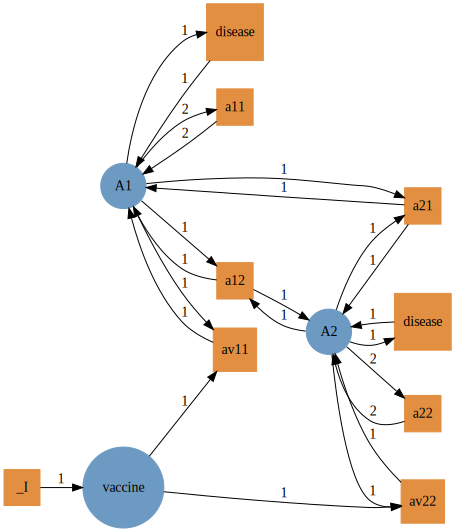

In [42]:
# Augment age (contact) model
# Permit all age states to have a "disease" self-interaction
typed_agev_aug = add_reflexives(
    typed_agev,
    [[:disease], [:disease], [], [], []],
    ontology
)

# Graph(dom(typed_age_aug))
Graph(dom(typed_agev_aug))

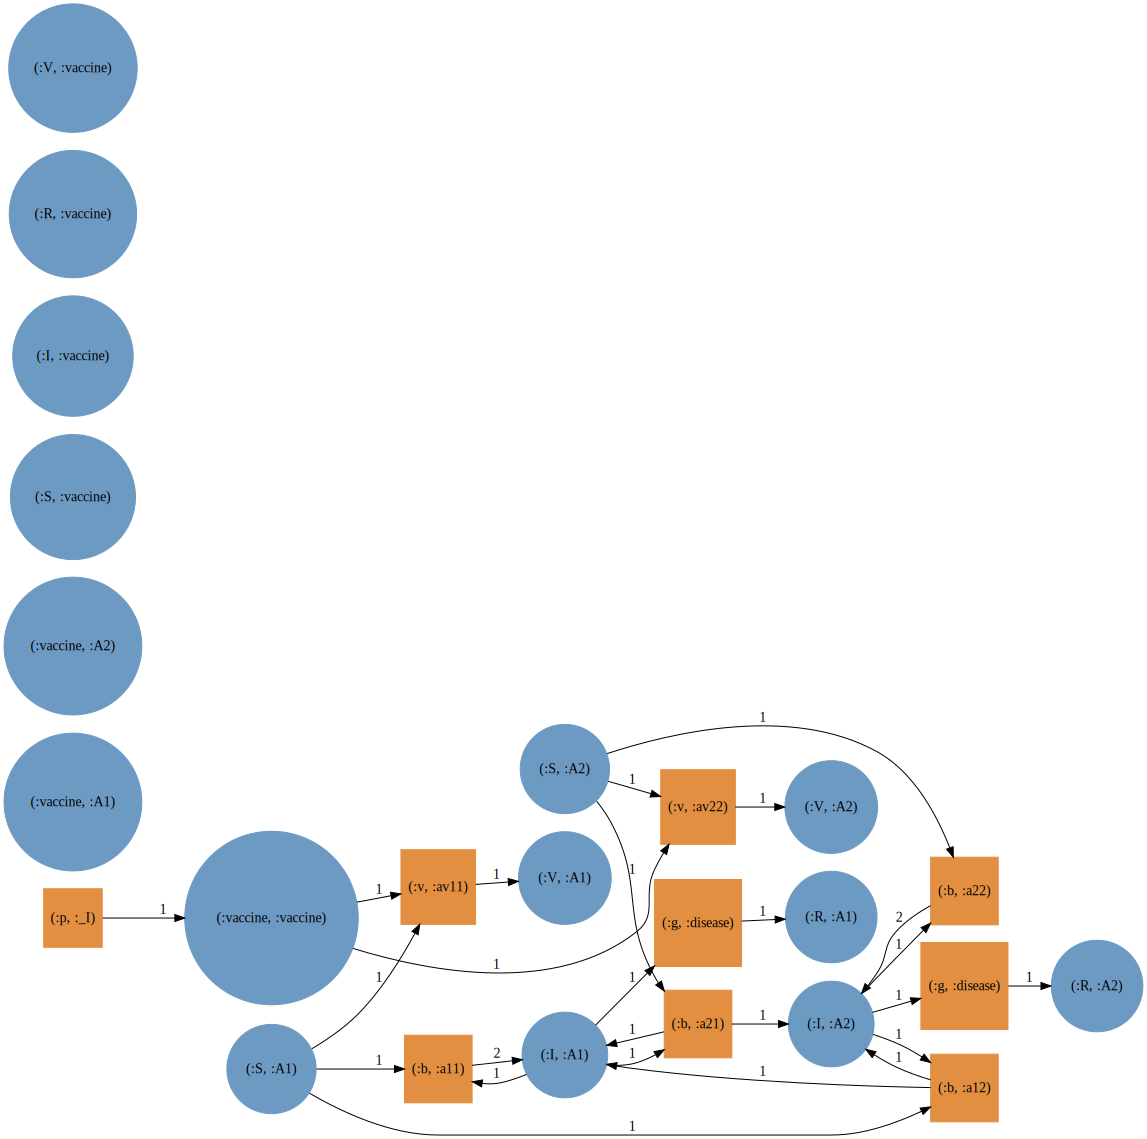

In [43]:
# Stratify SIRV and AgeV models
typed_sirv_age = typed_product(typed_sirv_aug, typed_agev_aug)

Graph(dom(typed_sirv_age))

Possible bug: `typed_product` generates state nodes combining state nodes of different types?

e.g. `(vaccine, X)` and `(Y, vaccine)` where `X, Y` are type `Pop`